# Assignment 2
Boxuan Zhang 12859928

# 1.	Introduction
The Algorithm I wish to implement is Histogram-of-Oriented Gradient(HOG) feature extraction and Local Binary Patterns(LBP) class definition for LBP feature extraction. These two algorithms are all image feature extract algorithm, HOG consists of calculating and statistic the gradient direction histogram of the local region of the image to form the feature. LBP is an operator used to describe the local texture features of an image; it has significant advantages such as rotation invariance and gray invariance. The extracted features are local texture features of the image. Both algorithms are popular in feature extraction.


# 2 Exploration
In this experiment, I will use MNIST dataset which provide 60000 train samples and 10000 test samples. The main challenge is to implement these two algorithms and compare their accuracy. Both of them has play an important role in some area, HoG is a popular algorithm in pedestrian detection, HoG features combined with SVM classifiers have been widely used in image recognition. In this report, I will try to use it and watch the performance. LBP is widely using in human face recognition. In this experiment, I choose this dataset because both two algorithms are not famous in this area, so it is suitable and fair to compare these two algorithms. 

The data model of HoG algorithm can be realized on divide the image into small connected areas which can be called cell, then collect every pixel in the cell to get a histogram, finally combine these histograms to form a feature descriptor. The process of realize this algorithm is that: first grayscale the image, then normalized it so that we can suppress noise interference. Next step is calculate the gradient of each pixel of image, that can weakening the influence of the illumination(we don’t influence by light in this experiment), divide the image into 6*6 pixel cells, count the gradient histogram of each cell to get the description. Then formed each cell into a block and the HoG feature of the block. Finally concatenating the HoG feature of each block and we can get the HoG feature of the whole image.

To extract the feature vector, we have to divide the detect window into 16*16 pixels for each cell, then for every pixel in the cell, compare the gray value with 8 pixels value. If the surrounding pixel value is greater than the center pixel value, the position of the pixel will be marked as 1, otherwise 0. In this way, 8 points in the 3*3 neighborhood are compared to generate an 9-bit binary number, then we can get the LBP value of the center pixel of the window is obtained. After that, calculate the histogram of each cell and then normalize the histogram. Finally, connect the obtain statistical histogram of each cell and get the LBP texture feature vector of the entire image, then using classifier to do the machine learning.


# 3 methodology
Now we are going to implement the Algorithm. First of all, we should import some necessary package 

In [0]:
import cv2
import os
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import classification_report
from skimage import feature 
from keras.datasets import mnist
from sklearn import metrics
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sn
import tensorflow as tf
import seaborn as sns

Using TensorFlow backend.


Next step is data preparation fortunately, we can directly import the dataset rather than upload from local, after import the data, let’s show some images and have a look. Then give a label, let's see some example.

In [0]:
import os
import struct
import numpy as np

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte'
                               % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

In [0]:
# Load the mnist dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()


X_train = X_train[:60000] 
y_train = y_train[:60000]
X_test = X_test[:10000]
y_test = y_test[:10000]

11493376/11490434 [==============================] - 1s 0us/step


In [0]:
# The 28X28 images are flattened to feature vector of size 784
# There 60,000 training examples in the training dataset
np.shape(X_train)
np.shape(X_test)

(10000, 28, 28)

In [0]:
X_train=X_train.reshape(-1,28,28)
X_test=X_test.reshape(-1,28,28)

# print the size of the result reshaped train and test data splits

print("Train dataset after reshaping:{}".format(np.shape(X_train)))
print("Test dataset after reshaping :{}".format(np.shape(X_test)))

labelNames = ["no.0", "no.1", "no.2", "no.3", "no.4","no.5", "no.6", "no.7", "no.8", "no.9"]

Train dataset after reshaping:(60000, 28, 28)
Test dataset after reshaping :(10000, 28, 28)


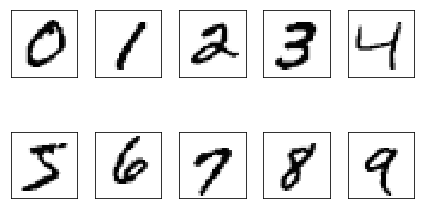

In [0]:
#show the images of the dataset
import matplotlib.pyplot as plt
fig, ax = plt.subplots(
    nrows=2,
    ncols=5,
    sharex=True,
    sharey=True, )

ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

no.3
no.0
no.5
no.3


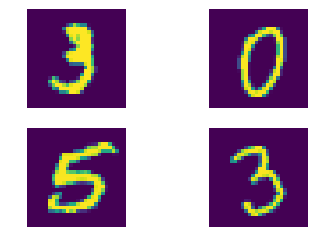

In [0]:
# view few images and print its corresponding label
img_index = 10
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.axis('off')
ax1.imshow(X_train[img_index])
print(labelNames[y_train[img_index]])

ax2 = fig.add_subplot(2,2,2)
ax2.axis('off')
img_index = 1000
ax2.imshow(X_train[img_index])
print(labelNames[y_train[img_index]])

ax2 = fig.add_subplot(2,2,3)
ax2.axis('off')
img_index = 20000
ax2.imshow(X_train[img_index])
print(labelNames[y_train[img_index]])

ax2 = fig.add_subplot(2,2,4)
ax2.axis('off')
img_index = 30000
ax2.imshow(X_train[img_index])
print(labelNames[y_train[img_index]])

Next step is implement the algorithm, let's start with HoG, the process step has been described in the part above, so in this part I will directly implement the structure and make some short explain with some comments.

In [0]:
# initialize the data matrix and labels
print("Extracting features from training dataset...")
data_train = []
labels_train = []

# loop over the training images
for img_index in range(len(X_train)):
  # load the image, and extract HOG features
  image = (X_train[img_index])
  #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  H = feature.hog(image, orientations=9, pixels_per_cell=(10, 10),
                  cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")
 
  # update the data and labels
  data_train.append(H)
  labels_train.append(y_train[img_index])

print(np.shape(data_train))
print(np.shape(labels_train))

Extracting features from training dataset...
(60000, 36)
(60000,)


In [0]:
img_index

59999

In [0]:
model = svm.SVC(kernel='rbf',C=100.0, random_state=42) # rbf Kernel
model.fit(data_train, labels_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=42,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
print("Train set Accuracy: {:.2f}".format(model.score(data_train,labels_train)))

Train set Accuracy: 0.88


In [0]:
# initialize the data matrix and labels
print("Extracting features from test dataset...")
predict_test = []
labels_test = []
data_test=[]
# loop over the training images
for img_ind in range(len(X_test)):
  # load the image, and extract HOG features
  img=X_test[img_ind]
  H = feature.hog(img, orientations=9, pixels_per_cell=(10, 10),
                  cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")
  pred = model.predict(H.reshape(1, -1))[0]
  # update the data and labels
  predict_test.append(pred)
  data_test.append(H)
  
  labels_test.append(y_test[img_ind])
  
print(np.shape(predict_test))
print(np.shape(labels_test))

Extracting features from test dataset...
(10000,)
(10000,)


In [0]:
# Test set Accuracy
accuracy = metrics.accuracy_score(y_test, predict_test)
print("Accuracy on test dataset:",accuracy)

Accuracy on test dataset: 0.8859


[[ 906    5   12    0    5    6   16    1   23    6]
 [   7 1113    2    3    4    0    3    1    2    0]
 [  10    3  894   41    8    5    2   39   24    6]
 [   2    0   43  872    0   29    0   20   32   12]
 [   6    5    9    0  874    2   69    3    5    9]
 [   2    3   11   41    1  786    6    3   28   11]
 [  19    4    0    0   38    9  879    0    5    4]
 [   4    7   55   39    1    5    0  894    6   17]
 [  42    2   17   44    9   26   23    3  763   45]
 [  14    6    7   12    4   22    2   16   48  878]]


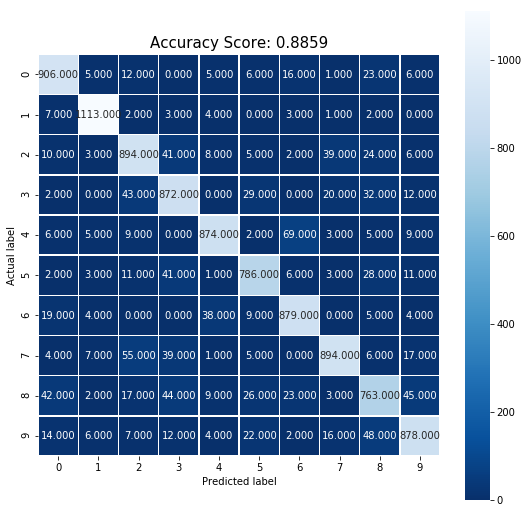

In [0]:
# plot the confusion matrix
cm  = metrics.confusion_matrix(y_test, predict_test)
print(cm)

# Plot confusion matrix using seaborn library
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);

In [0]:
images = []
orig_labels=[]
# randomly select a few testing fashion items
for i in np.random.choice(np.arange(0, len(y_test)), size=(16,)):
  # classify the clothing
  test_img = (X_test[i])
  H1 = feature.hog(test_img, orientations=9, pixels_per_cell=(10, 10),
                  cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")
  pred = model.predict(H1.reshape(1, -1))[0]
  #prediction = model.predict(test_img.reshape(1, -1))
  label = labelNames[pred]
  orig_labels.append(labelNames[y_test[i]])
  color = (0, 255, 0)
  test_img = cv2.merge([test_img] * 3)
  test_img = cv2.resize(test_img, (96, 96), interpolation=cv2.INTER_LINEAR)
  cv2.putText(test_img, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.50, color, 2)
  images.append(test_img)

In [0]:
orig_labels[1]

'no.0'

no.0
no.2
no.7
no.5


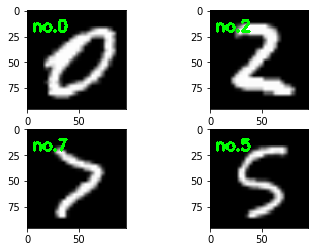

In [0]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(images[1])
print(orig_labels[1])
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(images[2])
print(orig_labels[2])
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(images[3])
print(orig_labels[3])
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(images[4])
print(orig_labels[4])

Next part is implement LBP algorithm

In [0]:
class LocalBinaryPatterns:
	def __init__(self, numPoints, radius):
		# store the number of points and radius
		self.numPoints = numPoints
		self.radius = radius
 
	def LBPfeatures(self, image, eps=1e-7):
		# compute the Local Binary Pattern representation
		# of the image, and then use the LBP representation
		# to build the histogram of patterns
		lbp = feature.local_binary_pattern(image, self.numPoints,
			self.radius, method="uniform")
    # Form the histogram
		(hist, _) = np.histogram(lbp.ravel(),
			bins=np.arange(0, self.numPoints + 3),
			range=(0, self.numPoints + 2))
 
		# normalize the histogram
		hist = hist.astype("float")
		hist /= (hist.sum() + eps)
 
		# return the histogram of Local Binary Patterns
		return hist

In [0]:
# Create an object of LocalBinaryPatterns class and initial the parameters.
desc = LocalBinaryPatterns(24, 8)
data_train = []
labels_train = []

# loop over the training images
for img_index in range(len(X_train)):
	# load the image, convert it to grayscale, and extract LBP features
	image = (X_train[img_index])
	hist = desc.LBPfeatures(image)
 
	# extract the label from the image path, then update the
	# label and data lists
	labels_train.append(y_train[img_index])
	data_train.append(hist)

In [0]:
# train a SVM clasifier on the training data
# Initialize the SVM model
model = svm.SVC(kernel='rbf',C=100.0, random_state=42) 
# Start training the SVM classifier 
model.fit(data_train, labels_train)

print(np.shape(data_train))
print(np.shape(labels_train))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


(60000, 26)
(60000,)


In [0]:
print("Train set Accuracy: {:.2f}".format(model.score(data_train,labels_train)))

Train set Accuracy: 0.45


In [0]:
predictions=[]
predict_label=[]
# Exract LBP features for each test sample and classify it with the trained SVM classifier
for im_index in range(len(X_test)):
  imag = X_test[im_index]
  # Extract LBP feature
  histo = desc.LBPfeatures(imag)
  # Perform classification
  prediction = model.predict(histo.reshape(1, -1))
  # Store the classfication result
  predictions.append(prediction)
  predict_label.append(y_test[im_index])

In [0]:
accuracy = metrics.accuracy_score(y_test, predictions)
print("Accuracy on test dataset:",accuracy)

Accuracy on test dataset: 0.4612


[[ 880    0    9   14    4   25    0    2    3   43]
 [   0 1086    8    1    3    0    0   35    2    0]
 [  40    2  485   61   32   73   17  179  116   27]
 [  97   21  159  182   81   96   40  161  110   63]
 [  11    3  106   30  319   18   16  105   77  297]
 [ 134   11  123   88   53  142   18  181   30  112]
 [  81   18  210   90   70   67   52  148  121  101]
 [   9   77   92   21   54   40   14  643   20   58]
 [  86    3   99  116   52   32   56   51  404   75]
 [  88   19   21   51  183   32   37  111   48  419]]


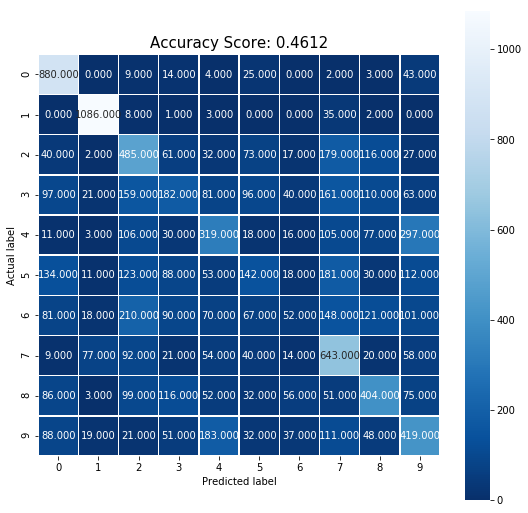

In [0]:
# plot the confusion matrix
cm  = metrics.confusion_matrix(y_test, predictions)
print(cm)

# Plot confusion matrix using seaborn library
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);

In [0]:
# Display the some classification result on test samples
images = []
 
# randomly select a few testing fashion items
for i in np.random.choice(np.arange(0, len(y_test)), size=(16,)):
  # classify the clothing
  histog = desc.LBPfeatures(X_test[i])
  prediction = model.predict(histog.reshape(1, -1))
  label = labelNames[prediction[0]]
  orig_label=labelNames[y_test[i]]
  image = X_test[i]
  color = (0, 255, 0)
  image = cv2.merge([image] * 3)
  image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
  cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.50, color, 2)
  images.append(image)

In [0]:
np.shape(images[1])

(96, 96, 3)

no.0


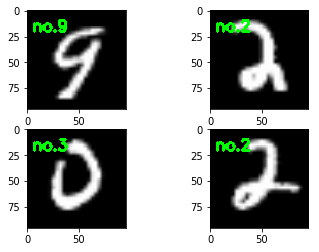

In [0]:
## Display the classification results
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(images[1])
print(orig_label[:])
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(images[2])
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(images[3])
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(images[4])

# 4 evaluation
From the result of experiment we can see that HoG model has a good accuracy reached 88%. The most important parameter of SVM is C and kernel. With the value of C become large, it will have High Variance, if the value of C become small, it will have High Bias. For kernel, when the value become high, it will lead to high Bias, if the value become small, it will lead High variance. For this experiment. When we try HoG feature, set kernel=rbf, C=100, we get the accuracy of the train set is 0.88.

LBP is not performing well in this experiment, from the accuracy we can see that the accuracy is lower than 50%, from the image we random shows we can also see a wrong recognition. It is an unacceptable accuracy, so I try to improve the value of C, let C=200 and C=500, from the result, we can see there is a little improvement but not enough. So, I change the value of kernel, from “rbf” to “linear”, because the linear parameters are mainly use in the case of linear separability. I wish different parameter of kernel can improvement of accuracy. Then I got a form below

kernel=rbf	
C=100, train 0.45  test 0.4612
C=200, train 0.46  test 0.4748
C=500, train 0.48  test 0.4877

kernel=linear
C=100, train 0.49  test 0.4996
C=200, train 0.49  test 0.5047
C=500, train 0.49  test 0.5118



# 5 conclusion
As we can see in the evaluation, HoG has a better accuracy than LBP. That means HoG is more suitable for this dataset than LBP. The reason cause that maybe it is suitable for HoG to do the detection in small space. And for LBP, the reason caused such a low accuracy maybe because some images of this dataset is blurry and can not be translate into binary mode. Actually, when we increase the value of C, the accuracy of LBP can be improved a little. However, to avoid overfitting, we should not set the value of C too large.


# 6 Ethical
For machine learning model, we have to consider some ethical problem, such as who will use the result of the experiment? What would they do with the results? Will it do harm to someone’s benefit? Fortunately, with the dataset I use, there is not lots of ethical problem, the only thing I can imagine to cause the problem is that someone collect the handwriting and try to imitate them to do some immoral things. That is an ethical problem we should avoid. We should protect the privacy of the data provider.

Although in this experiment, the dataset do not have some ethical problems, the algorithm it used may cause some ethical issue, HoG and LBP algorithm have wide used in pedestrian recognition and face recognition, both of them played a good performance in their application area, if someone got the dataset from the camera it may do harm to privacy, so we have to keep secret of the personal information, do not reveal these information to someone we can’t trust, after all, ethical issues are those thing legal but not moral, the best way to avoid it is do every thin conscientious.
